CellRanger run on fastqs by Marco prior to this script. This script will take raw UMI counts through QC, normalization, and batch correction to generate expression matrices for downstream analyses

In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(ggplot2, quietly = T)
    library(ggpubr, quietly = T)
    library(dplyr, quietly = T)
    library(reshape2, quietly = T)
})

In [2]:
# data_path = "/media/lewislab/Dropbox\ \(UCSD\ SBRG\)//Dropbox\ \(UCSD\ SBRG\)/Collaborations/Norcross_Lab/"
data_path = '/data2/hratch/FDA_collab/'
data_path2 = '/data3/hratch/norcross_abc/'


In [3]:
Untreated_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', 'my061_3_untreated_freshlnwithdc_dereg/filtered_feature_bc_matrix/'))
ABC_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my060_4_Day4_ABC_mcm_057m/filtered_feature_bc_matrix/"))
DT_Veh_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my060_2_Day4_DT_Veh_mcm_057m/filtered_feature_bc_matrix/"))
DT_ABC_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my060_3_Day4_DT_ABC_mcm_057m/filtered_feature_bc_matrix/"))
aCD4_ABC_data <- Read10X(data.dir = paste0(data_path, 'raw/fda_data/', "my061_4_anticd4abc_d4_freshlnwithdc_dereg/filtered_feature_bc_matrix/"))


# QC

In [4]:
# threshold on cell and feature cutoffs
raw_data<-list('UNTR' = Untreated_data, 'ABC' = ABC_data, 'DT_Veh' = DT_Veh_data, 'DT_ABC' = DT_ABC_data, 
               'aCD4_ABC' = aCD4_ABC_data)
so.list<-lapply(names(raw_data), function(n) CreateSeuratObject(counts = raw_data[[n]], project = n, 
                                                                    min.cells = 3, min.features = 200))
names(so.list)<-names(raw_data)

In [5]:
so.list

$UNTR
An object of class Seurat 
15127 features across 4010 samples within 1 assay 
Active assay: RNA (15127 features, 0 variable features)

$ABC
An object of class Seurat 
15417 features across 3982 samples within 1 assay 
Active assay: RNA (15417 features, 0 variable features)

$DT_Veh
An object of class Seurat 
16792 features across 6757 samples within 1 assay 
Active assay: RNA (16792 features, 0 variable features)

$DT_ABC
An object of class Seurat 
17301 features across 11398 samples within 1 assay 
Active assay: RNA (17301 features, 0 variable features)

$aCD4_ABC
An object of class Seurat 
17671 features across 15784 samples within 1 assay 
Active assay: RNA (17671 features, 0 variable features)


In [6]:
# get mitochondrial percentage
for (sample in names(so.list)){
    so.list[[sample]][['percent.mt']]<-PercentageFeatureSet(so.list[[sample]], pattern = "^mt-")
}

In [7]:
plot_QC<-function(so.list, name, 
                  nCount_RNA.upper = NULL, nCount_RNA.lower = NULL, 
                  nFeature_RNA.upper = NULL, nFeature_RNA.lower = NULL, percent.mt.upper = NULL, 
                  before = T, save = F){
    
    if (before){
        before_ = 'before'
    }else{
        before_ = 'after'
    }
    
    md<-so.list[[name]]@meta.data
    
    gAi<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
    theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                    axis.title.x=element_blank())
    if (!is.null(nFeature_RNA.upper) & before){gAi<-gAi + geom_hline(yintercept = nFeature_RNA.upper, color = 'blue')}
    if (!is.null(nFeature_RNA.lower) & before){gAi<-gAi + geom_hline(yintercept = nFeature_RNA.lower, color = 'blue')}


    gAii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
    theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                    axis.title.x=element_blank())
    if (!is.null(nCount_RNA.upper) & before){gAii<-gAii + geom_hline(yintercept = nCount_RNA.upper, color = 'blue')}
    if (!is.null(nCount_RNA.lower) & before){gAii<-gAii + geom_hline(yintercept = nCount_RNA.lower, color = 'blue')}


    gAiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
    theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                    axis.title.x=element_blank())
    if (!is.null(percent.mt.upper) & before){gAiii<-gAiii + geom_hline(yintercept = percent.mt.upper, color = 'blue')}

    gA<-ggarrange(gAi, gAii, gAiii, ncol = 3)

    gBi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")
    if (!is.null(nCount_RNA.upper) & before){gBi<-gBi + geom_vline(xintercept = nCount_RNA.upper, color = 'blue')}
    if (!is.null(nCount_RNA.lower) & before){gBi<-gBi + geom_vline(xintercept = nCount_RNA.lower, color = 'blue')}
    if (!is.null(percent.mt.upper) & before){gBi<-gBi + geom_hline(yintercept = percent.mt.upper, color = 'blue')}

    gBii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
    theme(legend.position="none")
    if (!is.null(nCount_RNA.upper) & before){gBii<-gBii + geom_vline(xintercept = nCount_RNA.upper, color = 'blue')}
    if (!is.null(nCount_RNA.lower) & before){gBii<-gBii + geom_vline(xintercept = nCount_RNA.lower, color = 'blue')}
    if (!is.null(nFeature_RNA.upper) & before){gBii<-gBii + geom_hline(yintercept = nFeature_RNA.upper, color = 'blue')}
    if (!is.null(nFeature_RNA.lower) & before){gBii<-gBii + geom_hline(yintercept = nFeature_RNA.lower, color = 'blue')}

    gB<-ggarrange(gBi, gBii, ncol = 2, nrow = 1)

    g<-ggarrange(gA, gB, ncol = 1, nrow = 2)
    g<-annotate_figure(g, top = text_grob(paste0(name, ', ', before_,' thresholding'), 
                   color = "black", face = "bold", size = 14))

    if (save){
        for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path2, 'figures/processing/', 
                                                         name, '_', before_, '_QC', ext), g)} 
    }

    return(g)
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



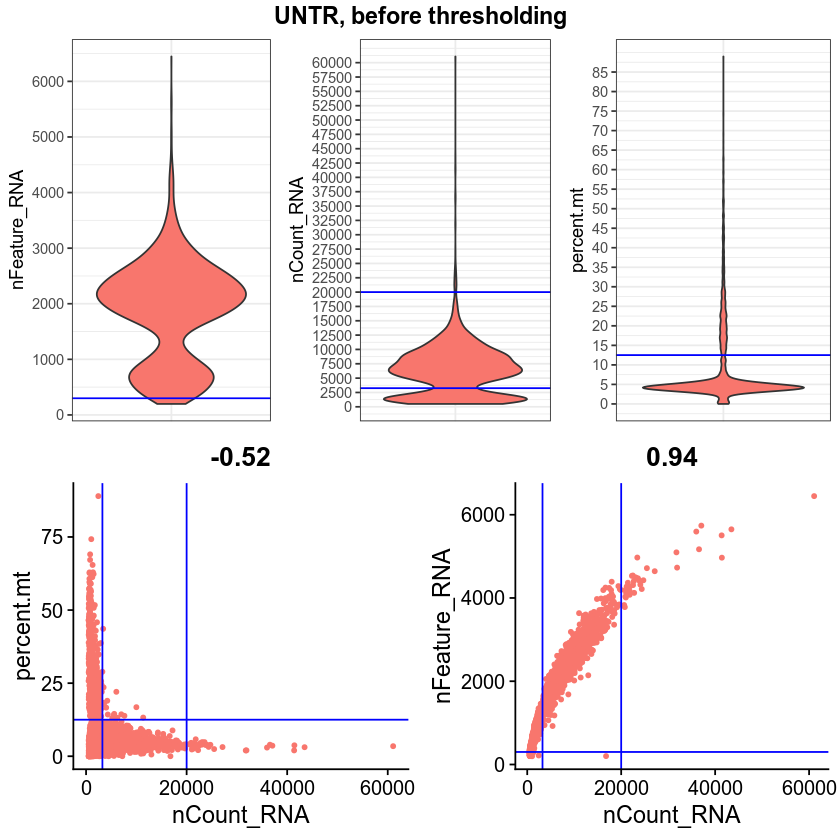

In [8]:
idx = 1
qc.thresh<-list(nCount_RNA.upper = 20000, nCount_RNA.lower = 3250, 
               nFeature_RNA.upper = NULL, nFeature_RNA.lower = 300, 
               percent.mt.upper = 12.5)
name = names(so.list)[[idx]]

g1A<-plot_QC(so.list = so.list, name = name, 
             nCount_RNA.upper = qc.thresh$nCount_RNA.upper, nCount_RNA.lower = qc.thresh$nCount_RNA.lower, 
             nFeature_RNA.upper = qc.thresh$nFeature_RNA.upper, nFeature_RNA.lower = qc.thresh$nFeature_RNA.lower, 
             percent.mt.upper = qc.thresh$percent.mt.upper,
             before = T, save = T)
g1A

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



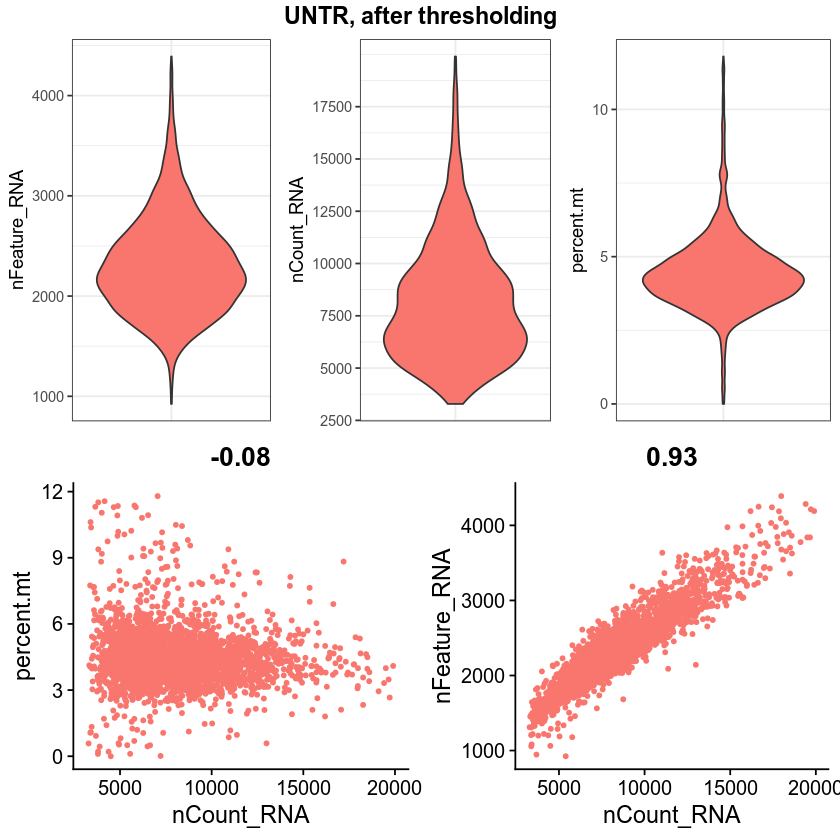

In [9]:
so.list[[name]] <- subset(so.list[[name]], 
                          subset = nCount_RNA > qc.thresh$nCount_RNA.lower & 
                                  nCount_RNA < qc.thresh$nCount_RNA.upper & 
                                   percent.mt < qc.thresh$percent.mt.upper &
                                   nFeature_RNA > qc.thresh$nFeature_RNA.lower)

g1B<-plot_QC(so.list = so.list, name = name, before = F, save = T)
g1B

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



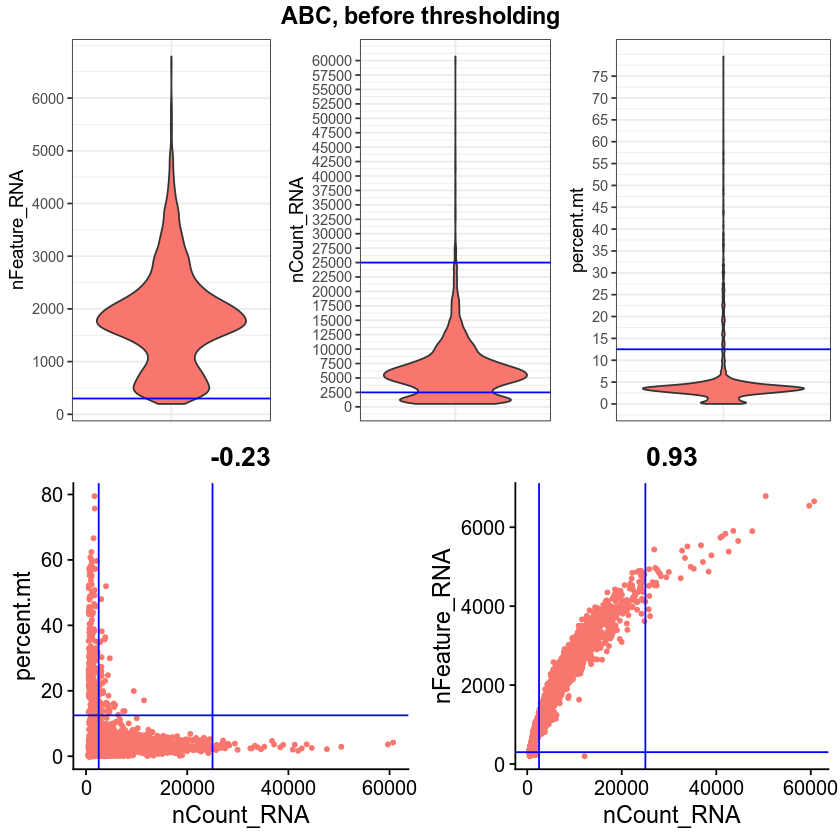

In [10]:
idx = 2
qc.thresh<-list(nCount_RNA.upper = 25000, nCount_RNA.lower = 2500, 
               nFeature_RNA.upper = NULL, nFeature_RNA.lower = 300, 
               percent.mt.upper = 12.5)
name = names(so.list)[[idx]]

g2A<-plot_QC(so.list = so.list, name = name, 
             nCount_RNA.upper = qc.thresh$nCount_RNA.upper, nCount_RNA.lower = qc.thresh$nCount_RNA.lower, 
             nFeature_RNA.upper = qc.thresh$nFeature_RNA.upper, nFeature_RNA.lower = qc.thresh$nFeature_RNA.lower, 
             percent.mt.upper = qc.thresh$percent.mt.upper,
             before = T, save = T)
g2A

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



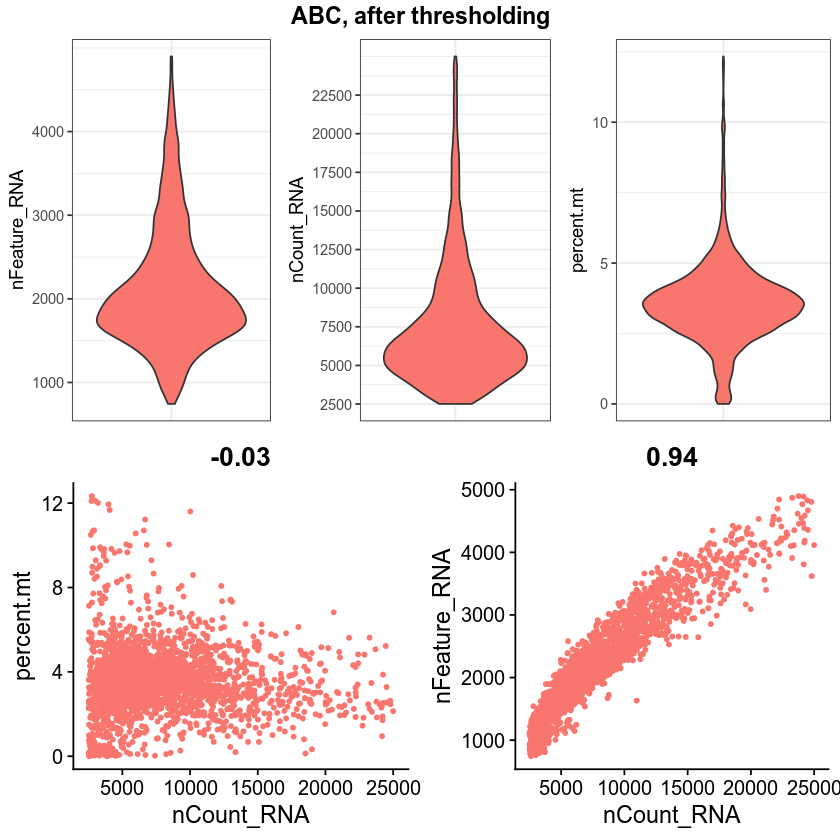

In [11]:
so.list[[name]] <- subset(so.list[[name]], 
                          subset = nCount_RNA > qc.thresh$nCount_RNA.lower & 
                                  nCount_RNA < qc.thresh$nCount_RNA.upper & 
                                   percent.mt < qc.thresh$percent.mt.upper &
                                   nFeature_RNA > qc.thresh$nFeature_RNA.lower)

g2B<-plot_QC(so.list = so.list, name = name, before = F, save = T)
g2B

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



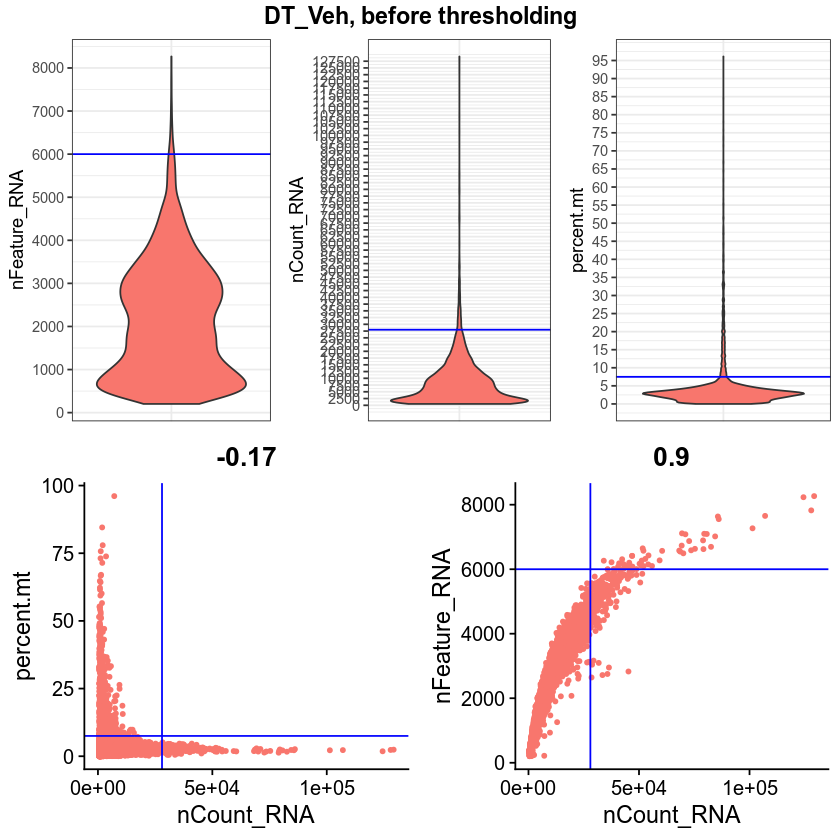

In [12]:
idx = 3
qc.thresh<-list(nCount_RNA.upper = 28000, nCount_RNA.lower = NULL, 
               nFeature_RNA.upper = 6000, nFeature_RNA.lower = NULL, 
               percent.mt.upper = 7.5)
name = names(so.list)[[idx]]

g3A<-plot_QC(so.list = so.list, name = name, 
             nCount_RNA.upper = qc.thresh$nCount_RNA.upper, nCount_RNA.lower = qc.thresh$nCount_RNA.lower, 
             nFeature_RNA.upper = qc.thresh$nFeature_RNA.upper, nFeature_RNA.lower = qc.thresh$nFeature_RNA.lower, 
             percent.mt.upper = qc.thresh$percent.mt.upper,
             before = T, save = T)
g3A

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



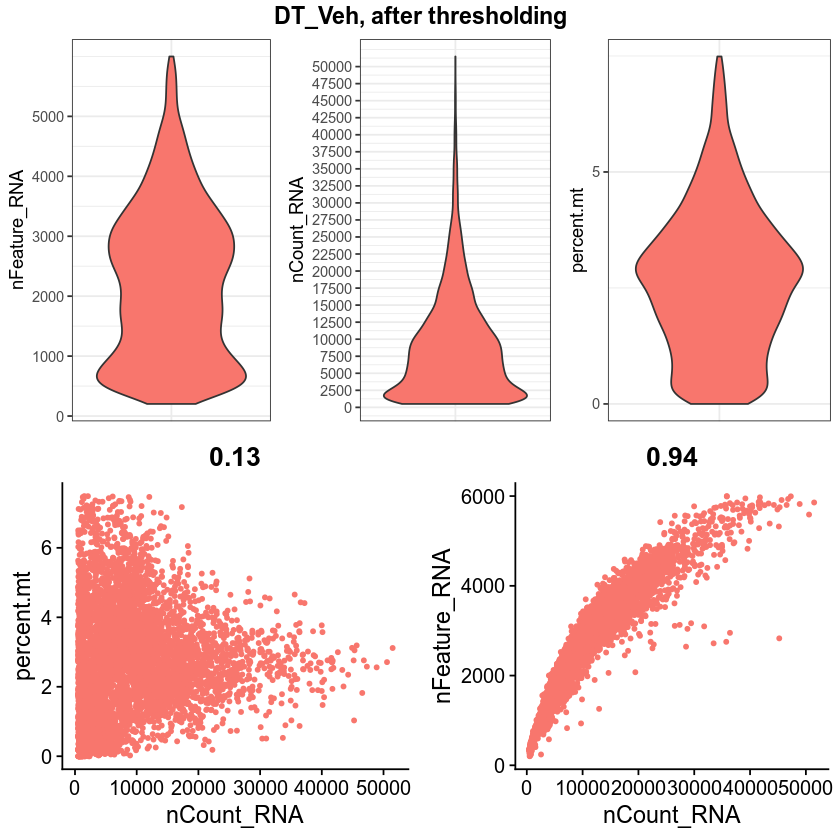

In [13]:
so.list[[name]] <- subset(so.list[[name]], 
                          subset = percent.mt < qc.thresh$percent.mt.upper &
                                    nFeature_RNA < qc.thresh$nFeature_RNA.upper)

g3B<-plot_QC(so.list = so.list, name = name, before = F, save = T)
g3B

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



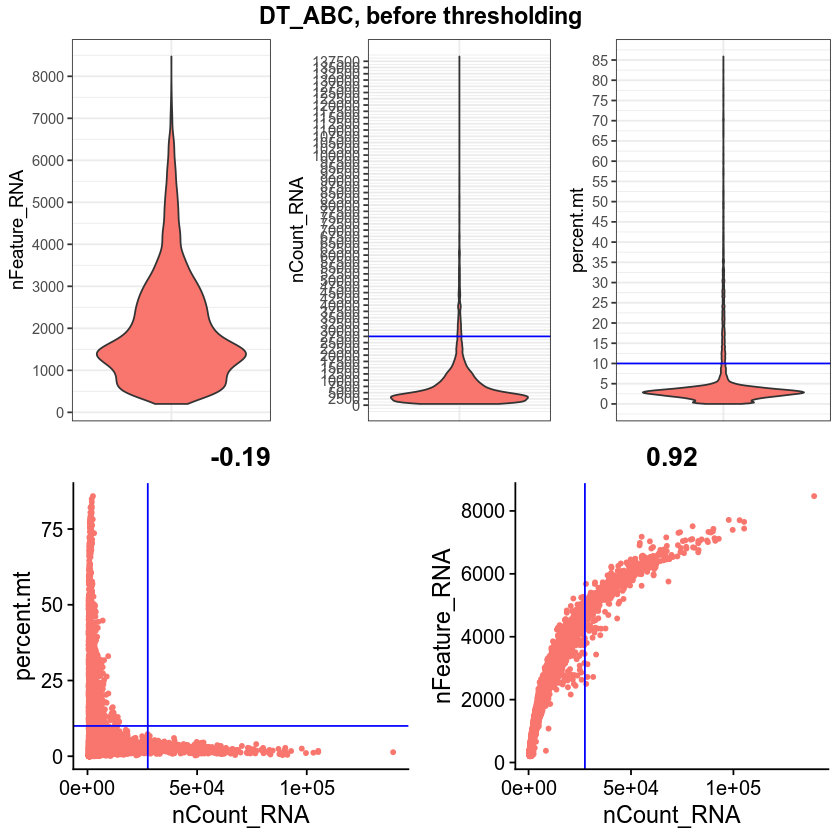

In [14]:
idx = 4
qc.thresh<-list(nCount_RNA.upper = 27500, nCount_RNA.lower = NULL, 
               nFeature_RNA.upper = NULL, nFeature_RNA.lower = NULL, 
               percent.mt.upper = 10)
name = names(so.list)[[idx]]

g4A<-plot_QC(so.list = so.list, name = name, 
             nCount_RNA.upper = qc.thresh$nCount_RNA.upper, nCount_RNA.lower = qc.thresh$nCount_RNA.lower, 
             nFeature_RNA.upper = qc.thresh$nFeature_RNA.upper, nFeature_RNA.lower = qc.thresh$nFeature_RNA.lower, 
             percent.mt.upper = qc.thresh$percent.mt.upper,
             before = T, save = T)
g4A

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



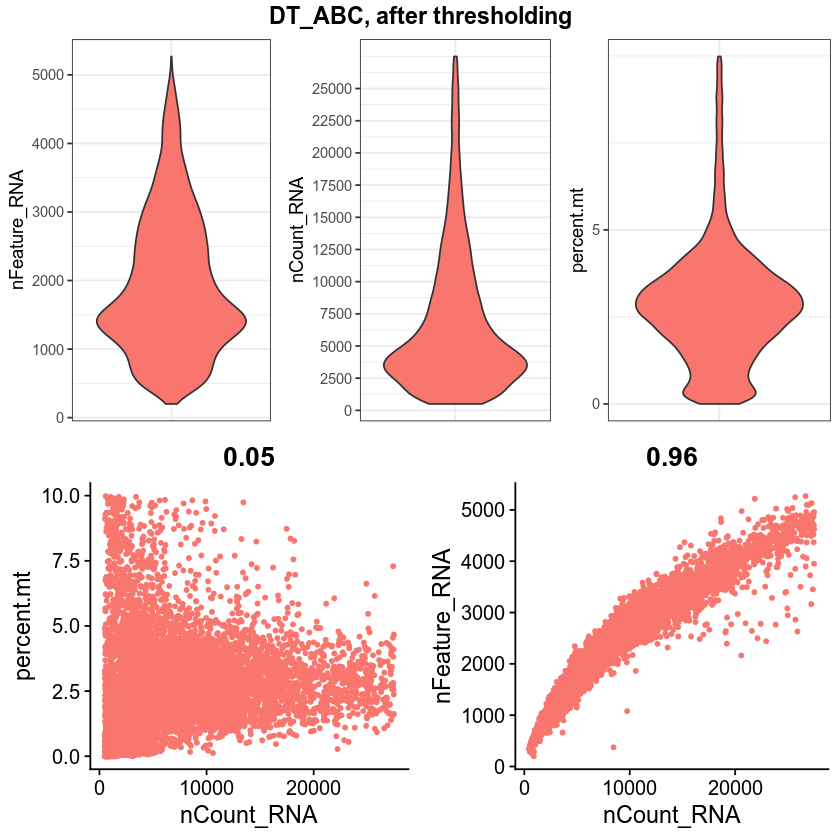

In [15]:
so.list[[name]] <- subset(so.list[[name]], 
                          subset = percent.mt < qc.thresh$percent.mt.upper &
                                  nCount_RNA < qc.thresh$nCount_RNA.upper)

g4B<-plot_QC(so.list = so.list, name = name, before = F, save = T)
g4B

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



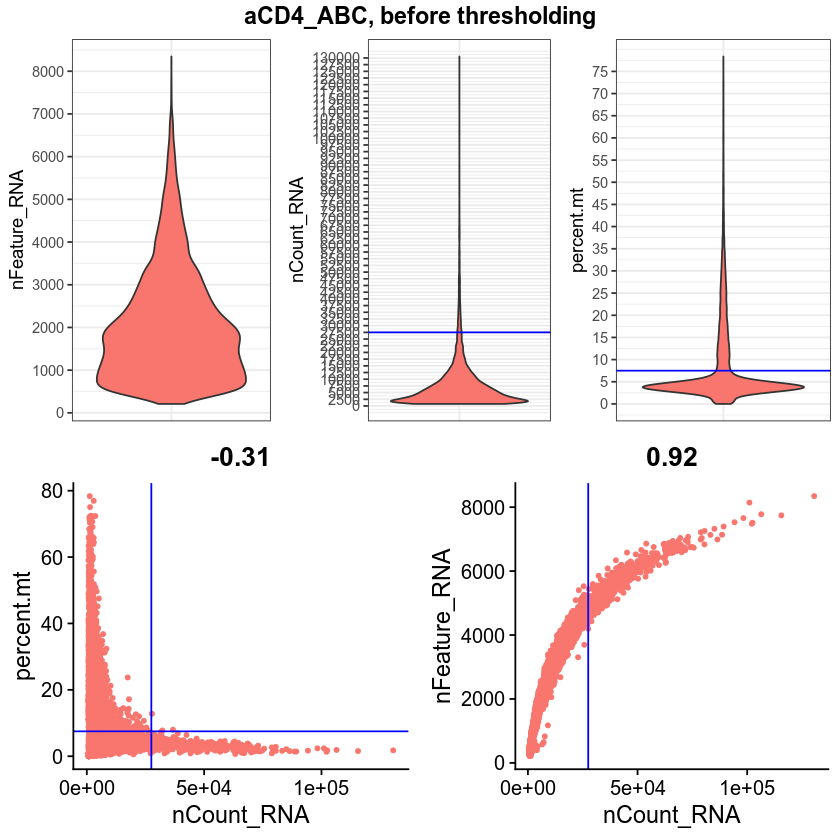

In [16]:
idx = 5
qc.thresh<-list(nCount_RNA.upper = 27500, nCount_RNA.lower = NULL, 
               nFeature_RNA.upper = NULL, nFeature_RNA.lower = NULL, 
               percent.mt.upper = 7.5)
name = names(so.list)[[idx]]

g5A<-plot_QC(so.list = so.list, name = name, 
             nCount_RNA.upper = qc.thresh$nCount_RNA.upper, nCount_RNA.lower = qc.thresh$nCount_RNA.lower, 
             nFeature_RNA.upper = qc.thresh$nFeature_RNA.upper, nFeature_RNA.lower = qc.thresh$nFeature_RNA.lower, 
             percent.mt.upper = qc.thresh$percent.mt.upper,
             before = T, save = T)
g5A

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



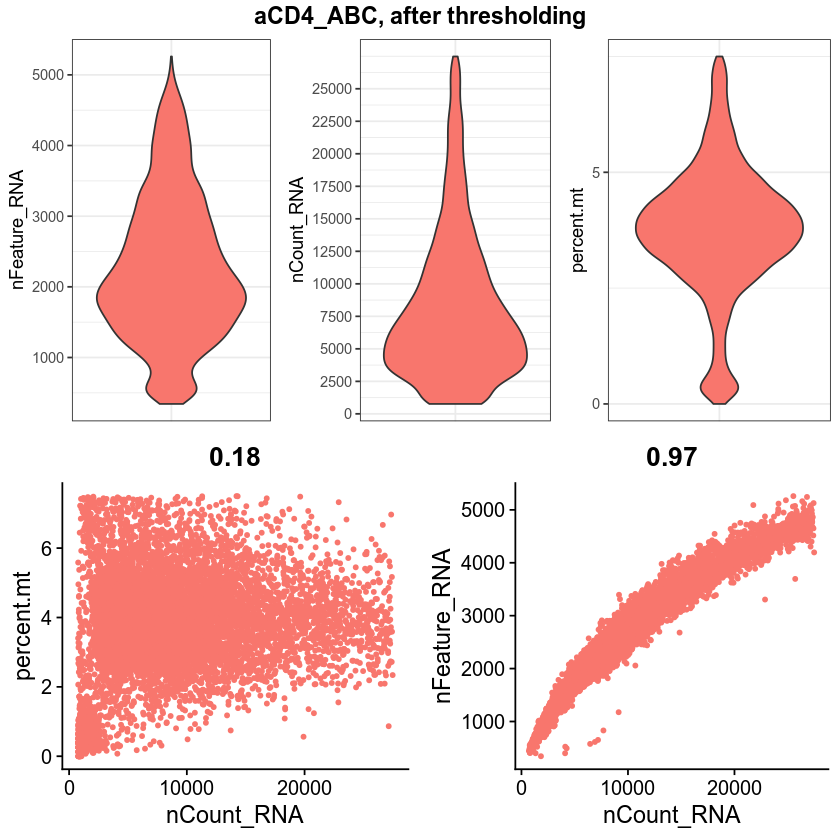

In [17]:
so.list[[name]] <- subset(so.list[[name]], 
                          subset = percent.mt < qc.thresh$percent.mt.upper &
                                  nCount_RNA < qc.thresh$nCount_RNA.upper)

g5B<-plot_QC(so.list = so.list, name = name, before = F, save = T)
g5B

In [18]:
so.list

$UNTR
An object of class Seurat 
15127 features across 2854 samples within 1 assay 
Active assay: RNA (15127 features, 0 variable features)

$ABC
An object of class Seurat 
15417 features across 3081 samples within 1 assay 
Active assay: RNA (15417 features, 0 variable features)

$DT_Veh
An object of class Seurat 
16792 features across 6003 samples within 1 assay 
Active assay: RNA (16792 features, 0 variable features)

$DT_ABC
An object of class Seurat 
17301 features across 9387 samples within 1 assay 
Active assay: RNA (17301 features, 0 variable features)

$aCD4_ABC
An object of class Seurat 
17671 features across 10350 samples within 1 assay 
Active assay: RNA (17671 features, 0 variable features)


# Normalize

In [19]:
so.list <- lapply(X = so.list, FUN = function(x){
    x <- NormalizeData(x, normalization.method = "LogNormalize", scale.factor = 1e6)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# Batch Correct

Use the reciprocal PCA method

In [20]:
features <- SelectIntegrationFeatures(object.list = so.list)
so.list <- lapply(X = so.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, npcs = 50, features = features, verbose = FALSE)
})

[1] "Additional variance explained is <0.5% at 11 pcs"
[1] "Additional variance explained is <0.5% at 13 pcs"
[1] "Additional variance explained is <0.5% at 12 pcs"
[1] "Additional variance explained is <0.5% at 11 pcs"
[1] "Additional variance explained is <0.5% at 10 pcs"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



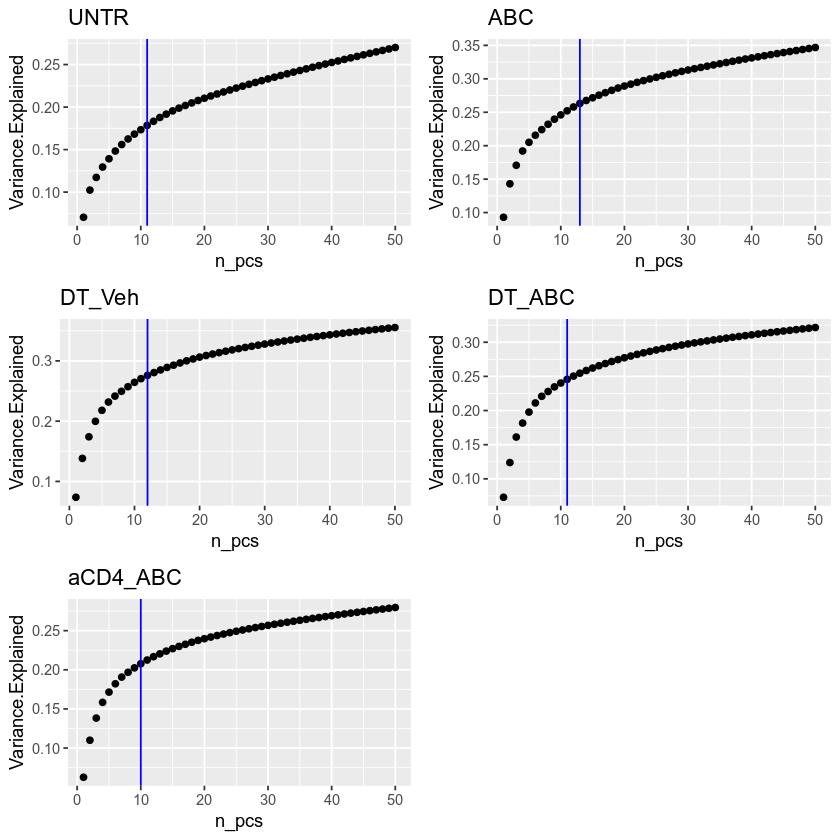

In [21]:
pca.var<-function(so, pc.thresh = 0.5){
    total_variance <- sum(matrixStats::rowVars(so@assays$RNA@scale.data))
    eigValues = (so@reductions$pca@stdev)^2
    varExplained = eigValues / total_variance


    viz_df = data.frame(varExplained)
    viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
    viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

    n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
    print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) # 48!
    g<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point() + 
    geom_vline(xintercept = n_pcs, color = 'blue')
    
    return(g)
}

g6<-lapply(names(so.list), function(name) pca.var(so.list[[name]])+ggtitle(name))
g6<-ggarrange(g6[[1]], g6[[2]], g6[[3]], g6[[4]], g6[[5]],  nrow = 3, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path2, 'figures/processing/', 
                                                     'sample_elbow_plot', ext), g6)}            
g6

In [22]:
suppressMessages({
    abc.anchors <- FindIntegrationAnchors(object.list = so.list, anchor.features = features, 
                                       scale = F, # since already scaled above, according to documentation
                                       normalization.method = 'LogNormalize', 
                                       reduction = "rpca")
    abc.integrated <- IntegrateData(anchorset = abc.anchors, normalization.method = 'LogNormalize')
})

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [23]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(abc.integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
abc.integrated <- ScaleData(abc.integrated, verbose = FALSE)
abc.integrated <- RunPCA(abc.integrated, npcs = 50, verbose = FALSE)

[1] "Additional variance explained is <0.1% at 44 pcs"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



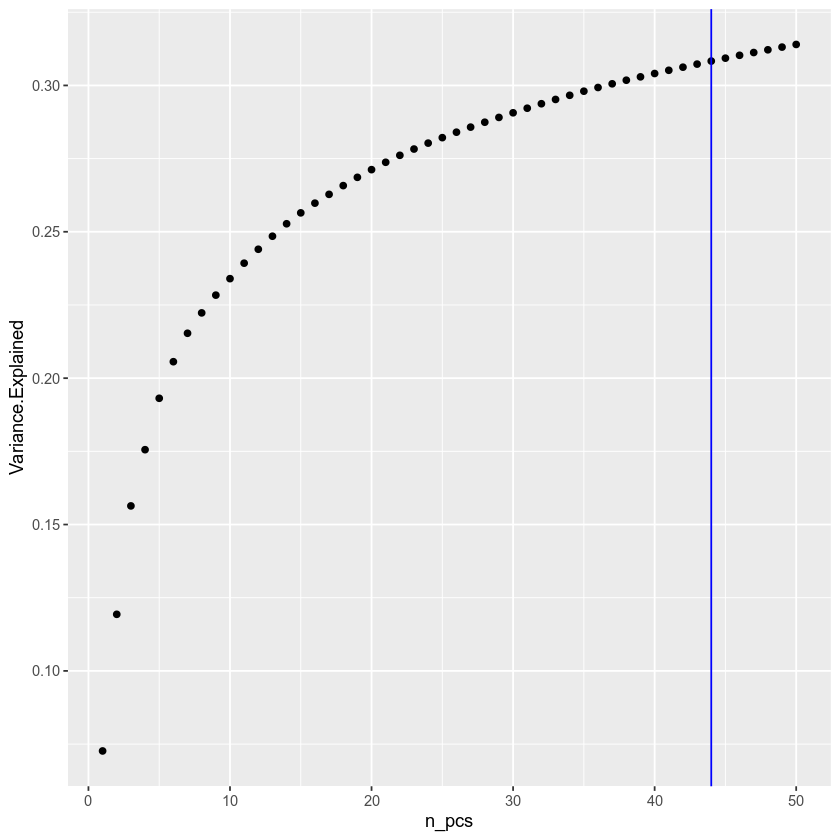

In [24]:
pc.thresh<-0.1
total_variance <- sum(matrixStats::rowVars(abc.integrated@assays$integrated@scale.data))
eigValues = (abc.integrated@reductions$pca@stdev)^2
varExplained = eigValues / total_variance


viz_df = data.frame(varExplained)
viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) 
g7<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point() + 
geom_vline(xintercept = n_pcs, color = 'blue')

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path2, 'figures/processing/', 
                                                     'integrated_elbow_plot', ext), g7)}     

g7

In [25]:
suppressWarnings({
    suppressMessages({
        abc.integrated <- RunUMAP(abc.integrated, reduction = "pca", dims = 1:n_pcs)
        abc.integrated <- FindNeighbors(abc.integrated, reduction = "pca", dims = 1:n_pcs)
        abc.integrated <- FindClusters(abc.integrated, resolution = 0.5)
    })
})

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31675
Number of edges: 1365965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9443
Number of communities: 27
Elapsed time: 6 seconds


In [26]:
abc.integrated <- FindClusters(abc.integrated, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31675
Number of edges: 1365965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9443
Number of communities: 27
Elapsed time: 6 seconds


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



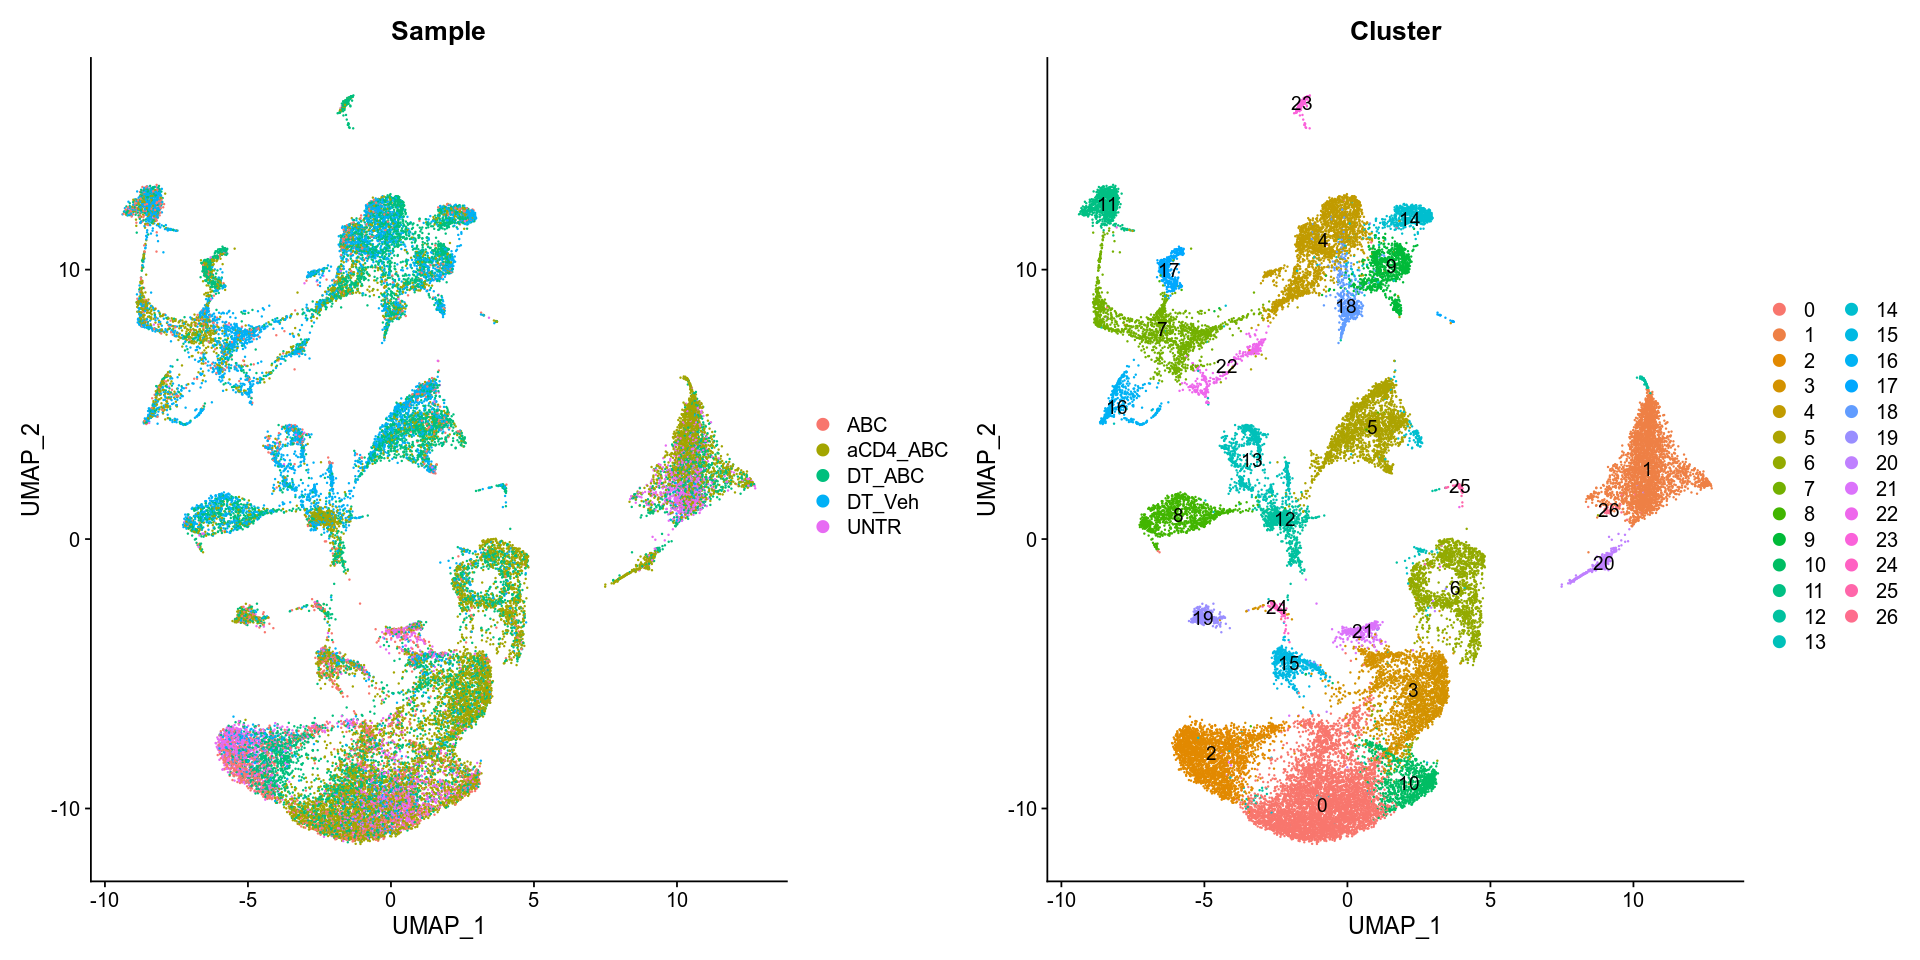

In [27]:
h_ = 8
w_ = 16
options(repr.plot.height=h_, repr.plot.width=w_)
g8a <- DimPlot(abc.integrated, reduction = "umap", group.by = "orig.ident", shuffle = T, label = F)+
ggtitle('Sample')
g8c <- DimPlot(abc.integrated, reduction = "umap", group.by = "seurat_clusters", shuffle = T,  label = T)+
ggtitle('Cluster')

g8<-g8a + g8c
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path2, 'figures/processing/', 
                                                     'UMAP_cluster', ext), g8)}     
g8

# Double Check Cluster QC

In [28]:
md<-abc.integrated@meta.data

In [29]:
# counts
table(md$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5556 3496 2579 2476 2356 2089 1645 1574  988  967  961  875  872  798  727  549 
  16   17   18   19   20   21   22   23   24   25   26 
 478  477  472  334  323  314  310  217  134   69   39 

In [30]:
# frequency
100*table(md$seurat_clusters)/dim(abc.integrated)[[2]]


         0          1          2          3          4          5          6 
17.5406472 11.0370955  8.1420679  7.8168903  7.4380426  6.5951066  5.1933702 
         7          8          9         10         11         12         13 
 4.9692186  3.1191792  3.0528808  3.0339384  2.7624309  2.7529597  2.5193370 
        14         15         16         17         18         19         20 
 2.2951855  1.7332281  1.5090766  1.5059195  1.4901342  1.0544594  1.0197316 
        21         22         23         24         25         26 
 0.9913181  0.9786898  0.6850829  0.4230466  0.2178374  0.1231255 

In [31]:
cell.counts<-count(md, seurat_clusters, orig.ident)
cell.counts<-dcast(cell.counts, orig.ident ~ seurat_clusters, value.var="n")
rownames(cell.counts)<-cell.counts$orig.ident
cell.counts<-cell.counts[colnames(cell.counts) != 'orig.ident']
cell.counts

,0,1,2,3,4,5,6,7,8,9,⋯,17,18,19,20,21,22,23,24,25,26
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ABC,863,12,720,108,121,107,38,141,13,50,⋯,23,20,62,1,92,17,1,39,NA,NA
aCD4_ABC,2468,1776,52,1421,338,211,959,496,146,106,⋯,153,77,132,223,34,45,44,30,1,9
DT_ABC,1225,773,840,759,1051,970,554,172,411,439,⋯,255,230,97,71,52,69,167,44,41,29
DT_Veh,233,56,233,122,840,786,83,760,408,371,⋯,41,142,23,NA,22,179,NA,8,27,1
UNTR,767,879,734,66,6,15,11,5,10,1,⋯,5,3,20,28,114,NA,5,13,NA,NA


In [32]:
# frequency of each cluster per sample
cell.freq<-t(apply(cell.counts, 1, function(i) 100*(i/sum(i[!is.na(i)]))))
cell.freq

,0,1,2,3,4,5,6,7,8,9,⋯,17,18,19,20,21,22,23,24,25,26
ABC,28.010386,0.3894839,23.3690360,3.505355,3.9272963,3.4728984,1.233366,4.5764362,0.4219409,1.62284972,⋯,0.7465109,0.6491399,2.0123337,0.03245699,2.9860435,0.5517689,0.03245699,1.2658228,NA,NA
aCD4_ABC,23.845411,17.1594203,0.5024155,13.729469,3.2657005,2.0386473,9.265700,4.7922705,1.4106280,1.02415459,⋯,1.4782609,0.7439614,1.2753623,2.15458937,0.3285024,0.4347826,0.42512077,0.2898551,0.009661836,0.08695652
DT_ABC,13.049963,8.2347928,8.9485459,8.085650,11.1963354,10.3334399,5.901779,1.8323213,4.3783957,4.67668052,⋯,2.7165229,2.4501971,1.0333440,0.75636519,0.5539576,0.7350591,1.77905614,0.4687334,0.436774262,0.30893789
DT_Veh,3.881393,0.9328669,3.8813926,2.032317,13.9930035,13.0934533,1.382642,12.6603365,6.7966017,6.18024321,⋯,0.6829918,2.3654839,0.3831418,NA,0.3664834,2.9818424,NA,0.1332667,0.449775112,0.01665834
UNTR,26.874562,30.7988788,25.7182901,2.312544,0.2102313,0.5255781,0.385424,0.1751927,0.3503854,0.03503854,⋯,0.1751927,0.1051156,0.7007708,0.98107919,3.9943938,NA,0.17519271,0.4555011,NA,NA


A few notes here:
1) Small cluysters 22-26 are frequently not present in all populations. May want to drop as a result. 
2) Some clusters within a sample are very few cells, so differences across context won't be possible in those comparisons

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



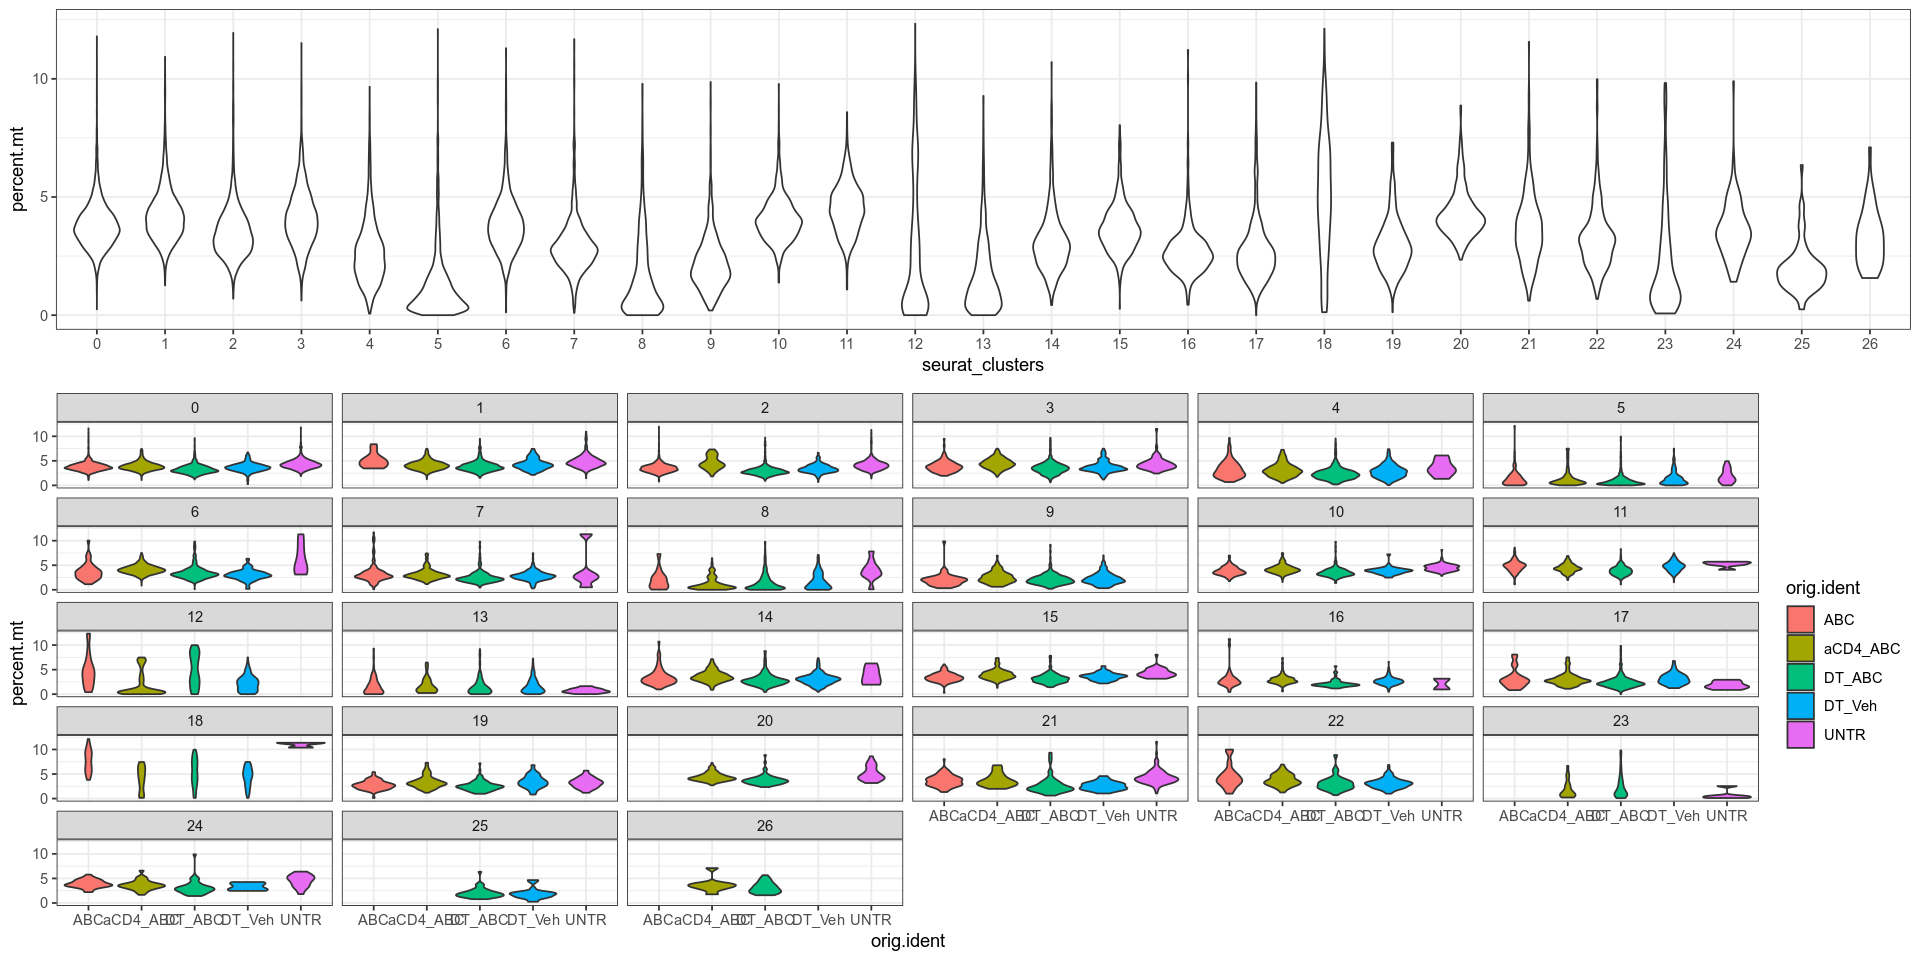

In [33]:
suppressWarnings({
    g9A<-ggplot(data = md, aes(x = seurat_clusters, y = percent.mt))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
    theme_bw()

    g9B<-ggplot(data = md, aes(y = percent.mt, x = orig.ident, fill = orig.ident))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
    theme_bw()+facet_wrap(~seurat_clusters)

    g9<-ggarrange(g9A, g9B, nrow = 2, heights = c(0.4, 0.6))
    for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path2, 'figures/processing/', 
                                                         'MT_QC_integrated', ext), g9)}   
})
  
g9

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



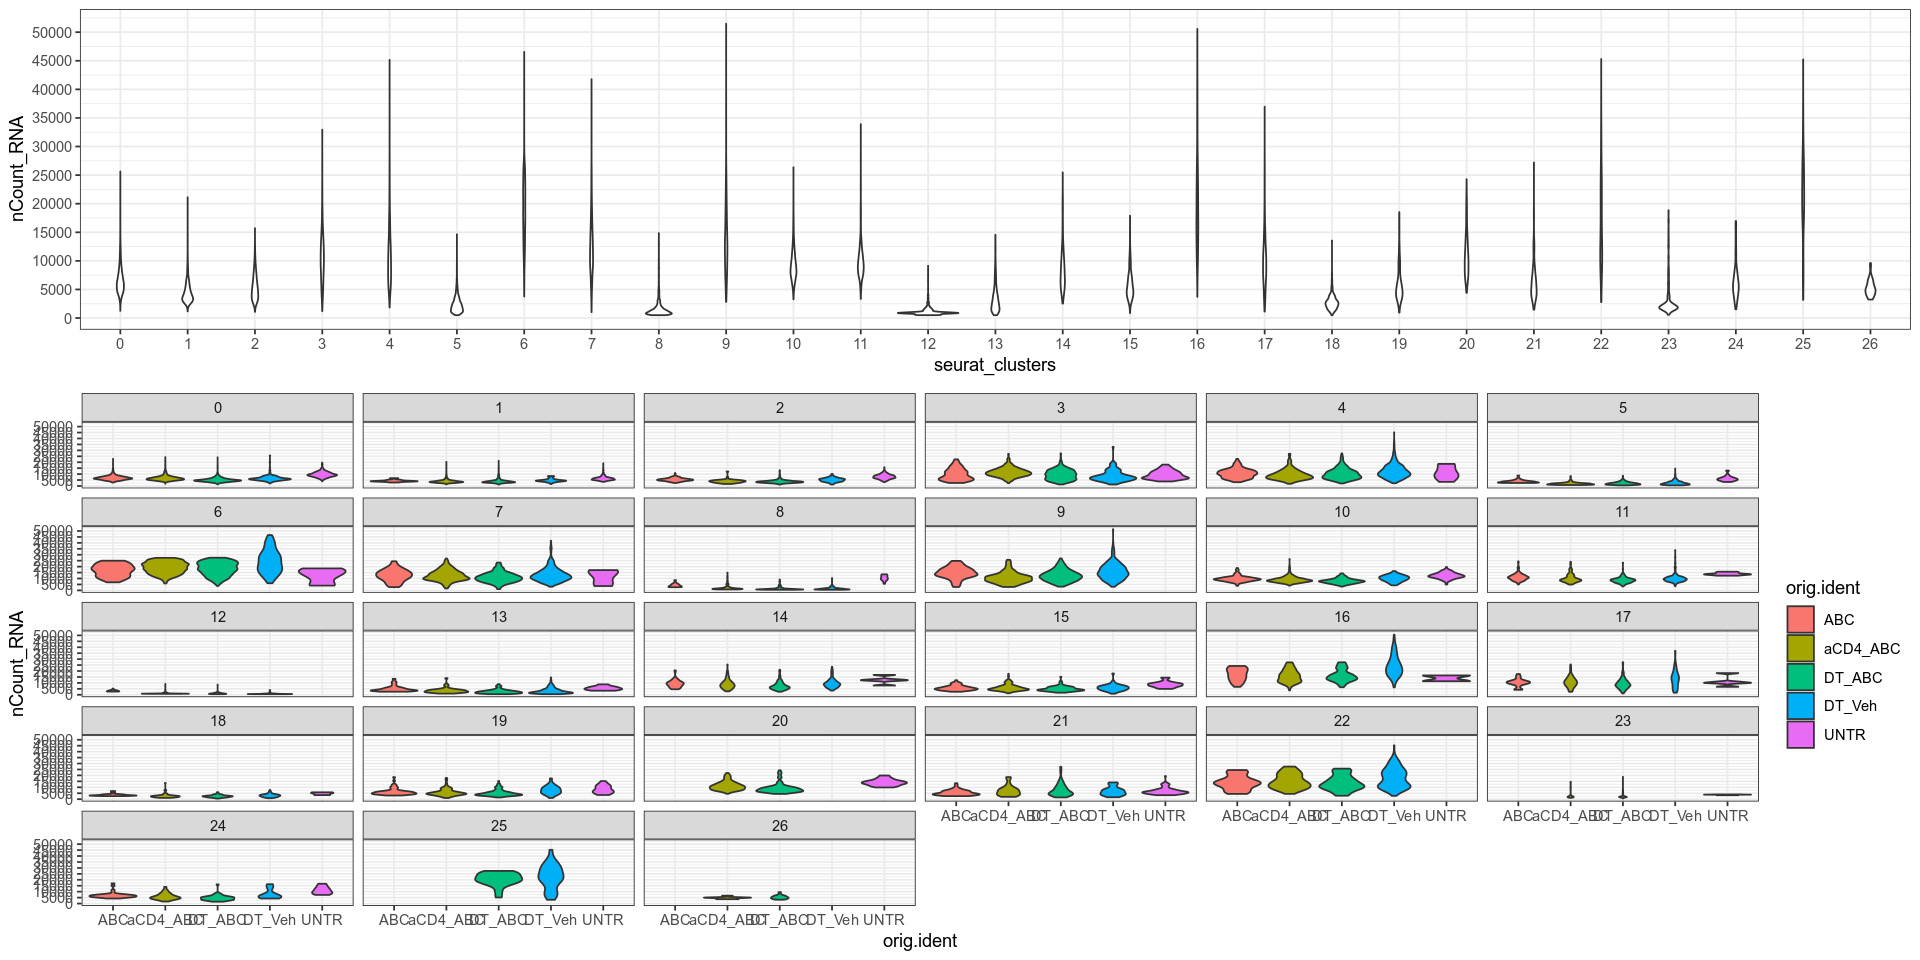

In [34]:
suppressWarnings({
    g10A<-ggplot(data = md, aes(x = seurat_clusters, y = nCount_RNA))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 5000),1))+
    theme_bw()

    g10B<-ggplot(data = md, aes(y = nCount_RNA, x = orig.ident, fill = orig.ident))+geom_violin()+
    scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 5000),1))+
    theme_bw()+facet_wrap(~seurat_clusters)

    g10<-ggarrange(g10A, g10B, nrow = 2, heights = c(0.4, 0.6))
    for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path2, 'figures/processing/', 
                                                         'nCount_QC_integrated', ext), g10)}    
})  
g10

In [35]:
# final formating before saving
abc.integrated@meta.data[['orig.ident']]<-factor(abc.integrated@meta.data$orig.ident, 
                                                  levels = c('UNTR', 'ABC', 'DT_Veh', 'DT_ABC', 'aCD4_ABC'))

# make sure that the log(1+CPM) also has a scaled matrix
DefaultAssay(abc.integrated)<-'RNA'
abc.integrated <- ScaleData(abc.integrated, features = rownames(abc.integrated))
DefaultAssay(abc.integrated)<-'integrated'

saveRDS(abc.integrated, 
        file = paste0(data_path2, 'interim/abc_integrated.RDS'))

Centering and scaling data matrix

